# What happens if I fit a mass-gainer with single star models?

In [1]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

import astropy.constants as const
import astropy.units as u

from astropy.visualization import quantity_support
quantity_support()

from ipywidgets import interact, IntSlider, FloatSlider

import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load and prep data

Add some custom imports will Earl's `mesagrid` package and my mesa plotting scripts.

In [3]:
from importlib import reload
import sys
sys.path.append("../../")

import mesagrid
reload(mesagrid);

sys.path.append("../../helpers")
import mpt

In [4]:
from types import ModuleType
def refresh_mpt():
    rreload(mpt)
    rreload(mpt)

def rreload(module):
    """Recursively reload modules."""
    reload(module)
    for attribute_name in dir(module):
        attribute = getattr(module, attribute_name)
        if type(attribute) is ModuleType:
            if attribute_name in ["hr", "profiles", "period_spacing", "utils"]:
                rreload(attribute)

In [5]:
track = mesagrid.Track("../../output/cluster/binaries/Dmix_grid/D_20", dir_name="LOGS_star2", parameters="Mass-gainer")

In [82]:
single_tracks = {}
Ms = np.arange(3.0, 6.1, 0.1)
for M in Ms:
    folder = f"M_{M:1.1f}"
    single_tracks[folder] = mesagrid.Track(dir=f"../../output/cluster/singles_grid_mdm20/{folder}", parameters=folder)
mod_names = [f"M_{M:1.1f}" for M in Ms]

In [7]:
def chi2_2D(p_mg, dp_mg, p_s, dp_s, norm=None):
    if norm is None:
        norm = (dp_mg.max() - dp_mg.min()) / (p_mg.max() - p_mg.min())

    p_mg, dp_mg, p_s, dp_s = p_mg.value, dp_mg.value, p_s.value, dp_s.value

    p_diff = (p_mg[:, None] - p_s[None, :])**2
    dp_diff = ((p_mg[:, None] - p_s[None, :]) / norm)**2

    chi2 = np.min(p_diff + dp_diff, axis=1).sum()

    # sanity check
    assert np.isfinite(chi2)

    return chi2

In [39]:
p_s[25:25+20].value

array([2.45917129, 2.39841685, 2.33773848, 2.27714554, 2.21661806,
       2.15610322, 2.0955684 , 2.0350588 , 1.97465795, 1.91440698,
       1.854247  , 1.79407234, 1.73388459, 1.67381737, 1.61399169,
       1.55433733, 1.49465872, 1.43485256, 1.37498414, 1.31514442])

In [60]:
import astropy.units as u
import numpy as np
from scipy.optimize import linear_sum_assignment
from itertools import product

def chi_period(p_s, p_mg=None, x=None, p_min=1.0, n_modes=20):
    # if x is not directly supplied then compute it
    if x is None:
        # sort mass-gainer periods and remove units
        p_mg = np.sort(p_mg.to(u.d).value)

        # take the first n modes after period p_min
        x = p_mg[p_mg > p_min][:n_modes]

    # sort single star periods and remove units
    p_s = np.sort(p_s.to(u.d).value)

    # find the closest period to the starting mass-gainer period 
    # ------------ THIS FEELS LIKE IT COULD BE WRONG -----------
    y_start = np.abs(p_s - x[0]).argmin()

    # get the 20 modes after this matching period
    y = p_s[y_start:y_start + n_modes]

    # if for some reason there aren't 20 modes in either case then return infinity
    if len(y) != len(x) or len(x) != n_modes or len(y) != n_modes:
        return np.inf
    
    # calculate the cost matrix for the periods
    cost_matrix = np.zeros((len(x), len(y)))
    x_ind, y_ind = np.arange(len(x)), np.arange(len(y))
    for i, j in product(x_ind, y_ind):
        cost_matrix[i, j] = abs(x[i] - y[j])

    # use scipy to find the optimal assignment of modes
    opt_assignment = linear_sum_assignment(cost_matrix)

    # calculate chi^2
    measured_periods = x[opt_assignment[0]]
    model_periods = y[opt_assignment[1]]
    return np.sum((measured_periods - model_periods)**2)

In [78]:
from scipy.interpolate import interp1d

In [84]:
%%time
p_mg, _, _ = mpt.get_delta_p(track, X_c=0.1)
p_mg = np.sort(p_mg.to(u.d).value)
x = p_mg[p_mg > 1.0][:20]

chis = [[chi_period(p_s=mpt.get_delta_p(single_tracks[mod_name], mod=i)[0], x=x) for i in range(len(single_tracks[mod_name].freqs))] for mod_name in mod_names]


CPU times: user 17 s, sys: 13.9 ms, total: 17 s
Wall time: 17 s


In [89]:
x_cs = [single_tracks[mod_name].history["center_h1"].values for mod_name in mod_names]

In [91]:
chi_funcs = [interp1d(x_c, chi, fill_value="extrapolate") for x_c, chi in zip(x_cs, chis)]

In [104]:
x_c_range = np.linspace(1e-5, 0.698, 1000)

XC, M = np.meshgrid(x_c_range, Ms)

In [108]:
CHI = np.asarray([chi_funcs[i](x_c_range) for i in range(len(chi_funcs))])

In [121]:
np.argmin(CHI)

8083

Text(0, 0.5, 'Stellar mass, $M \\, [\\rm M_\\odot]$')

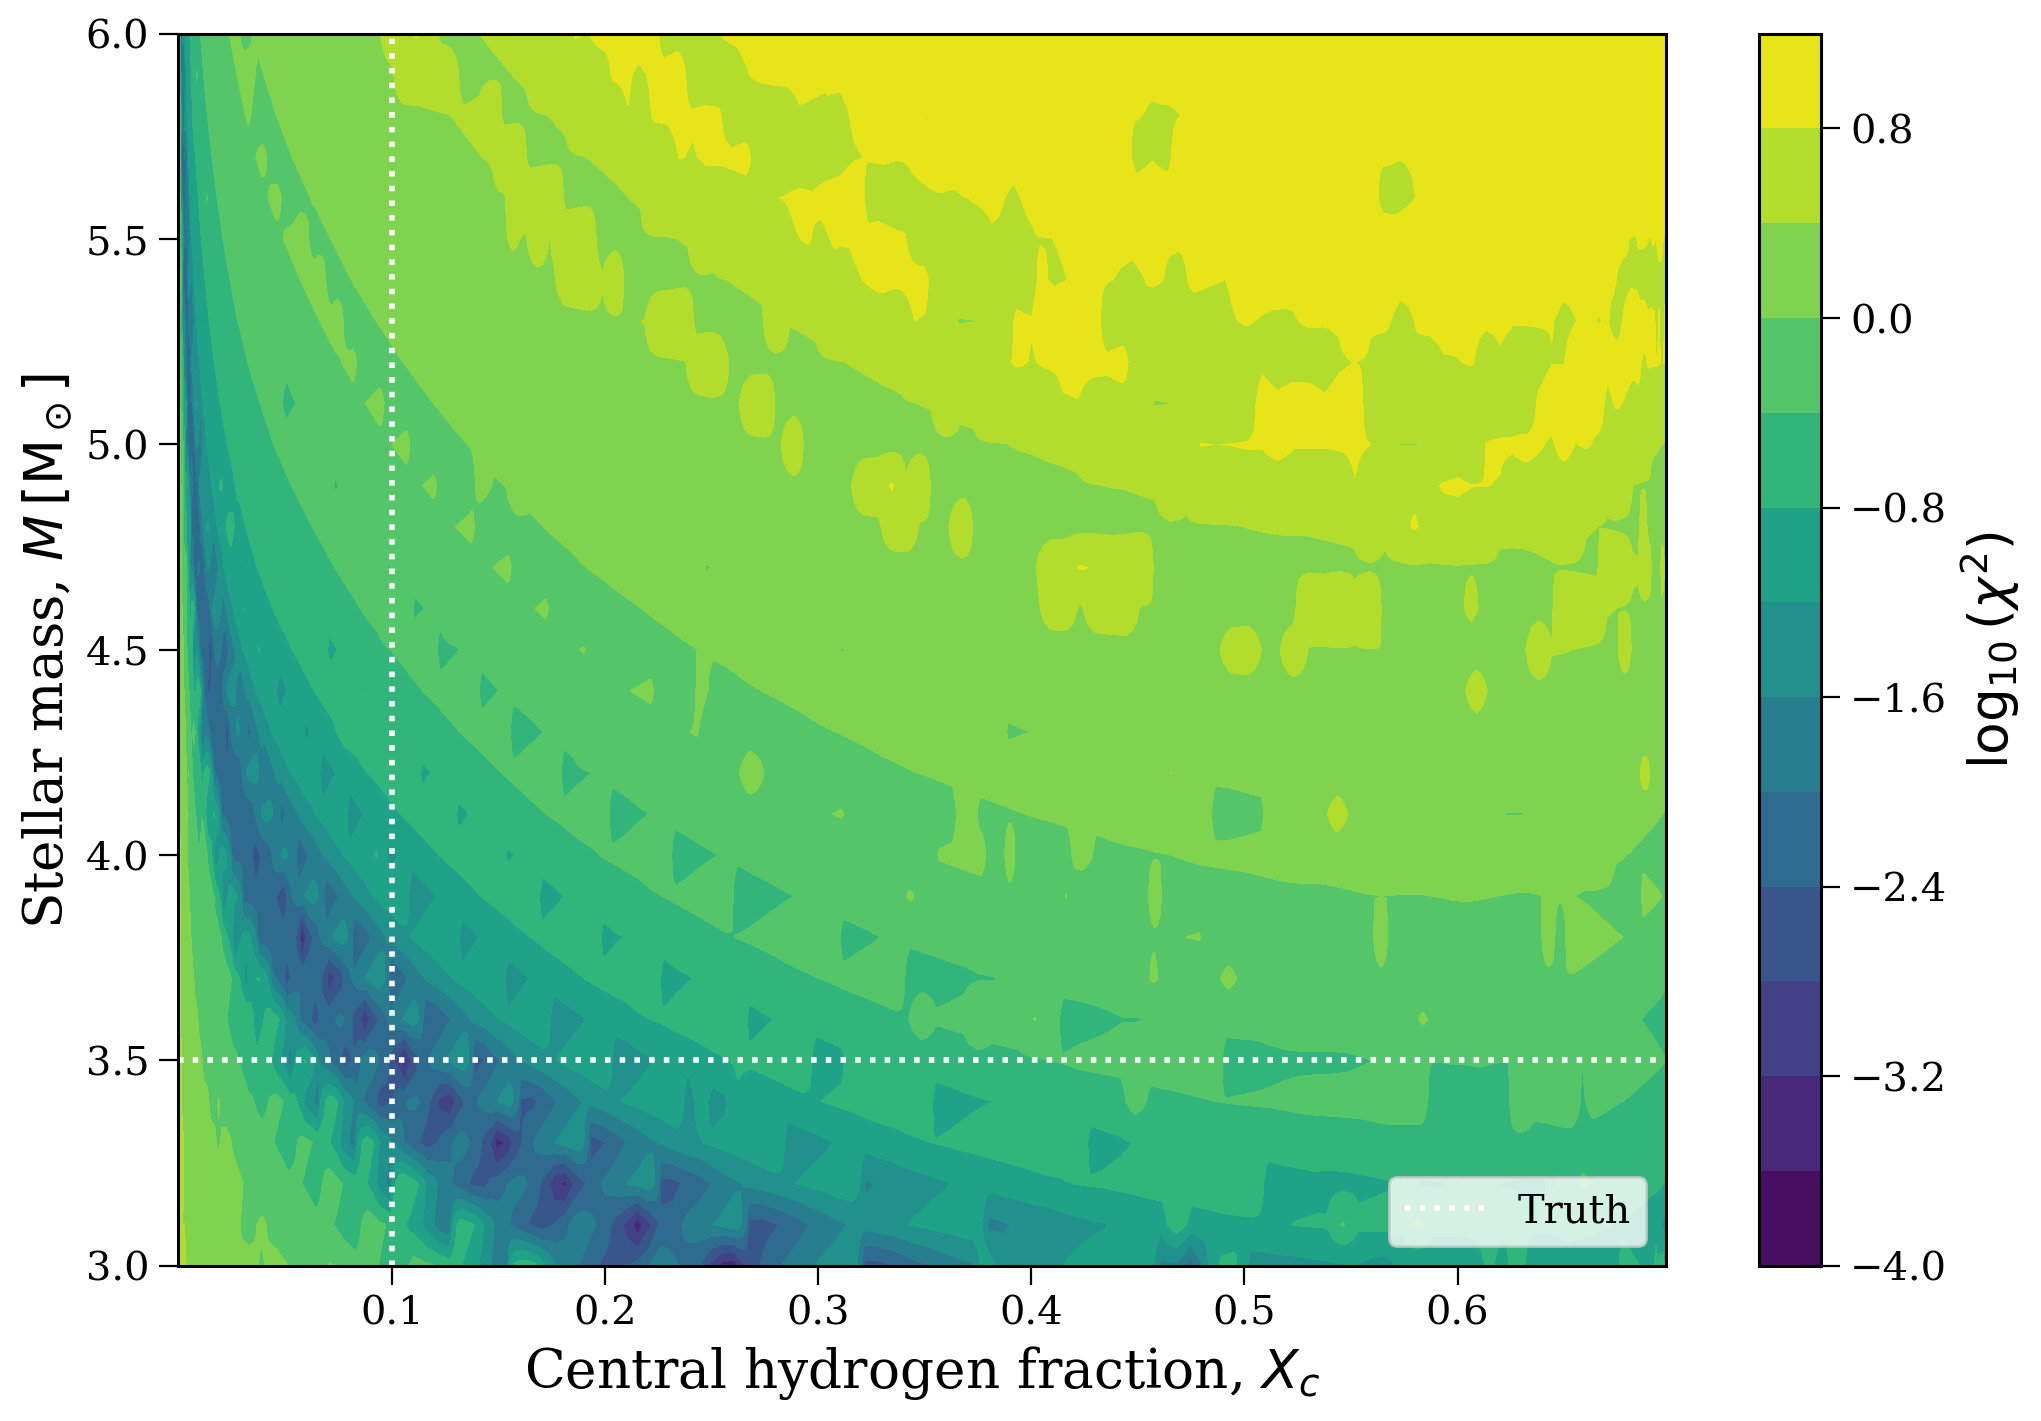

In [151]:
fig, ax = plt.subplots()

cont = ax.contourf(XC, M, np.log10(CHI), levels=15)
fig.colorbar(cont, label=r"$\log_{10}(\chi^2)$")



plt.axvline(0.1, color="white", linestyle="dotted", lw=2, label="Truth")
plt.axhline(3.5, color="white", linestyle="dotted", lw=2)
plt.legend(loc="lower right")


ax.set_xlabel(r"Central hydrogen fraction, $X_c$")
ax.set_ylabel(r"Stellar mass, $M \, [\rm M_\odot]$")

In [134]:
Ms[5]

3.5000000000000004

0.00033049269885820865


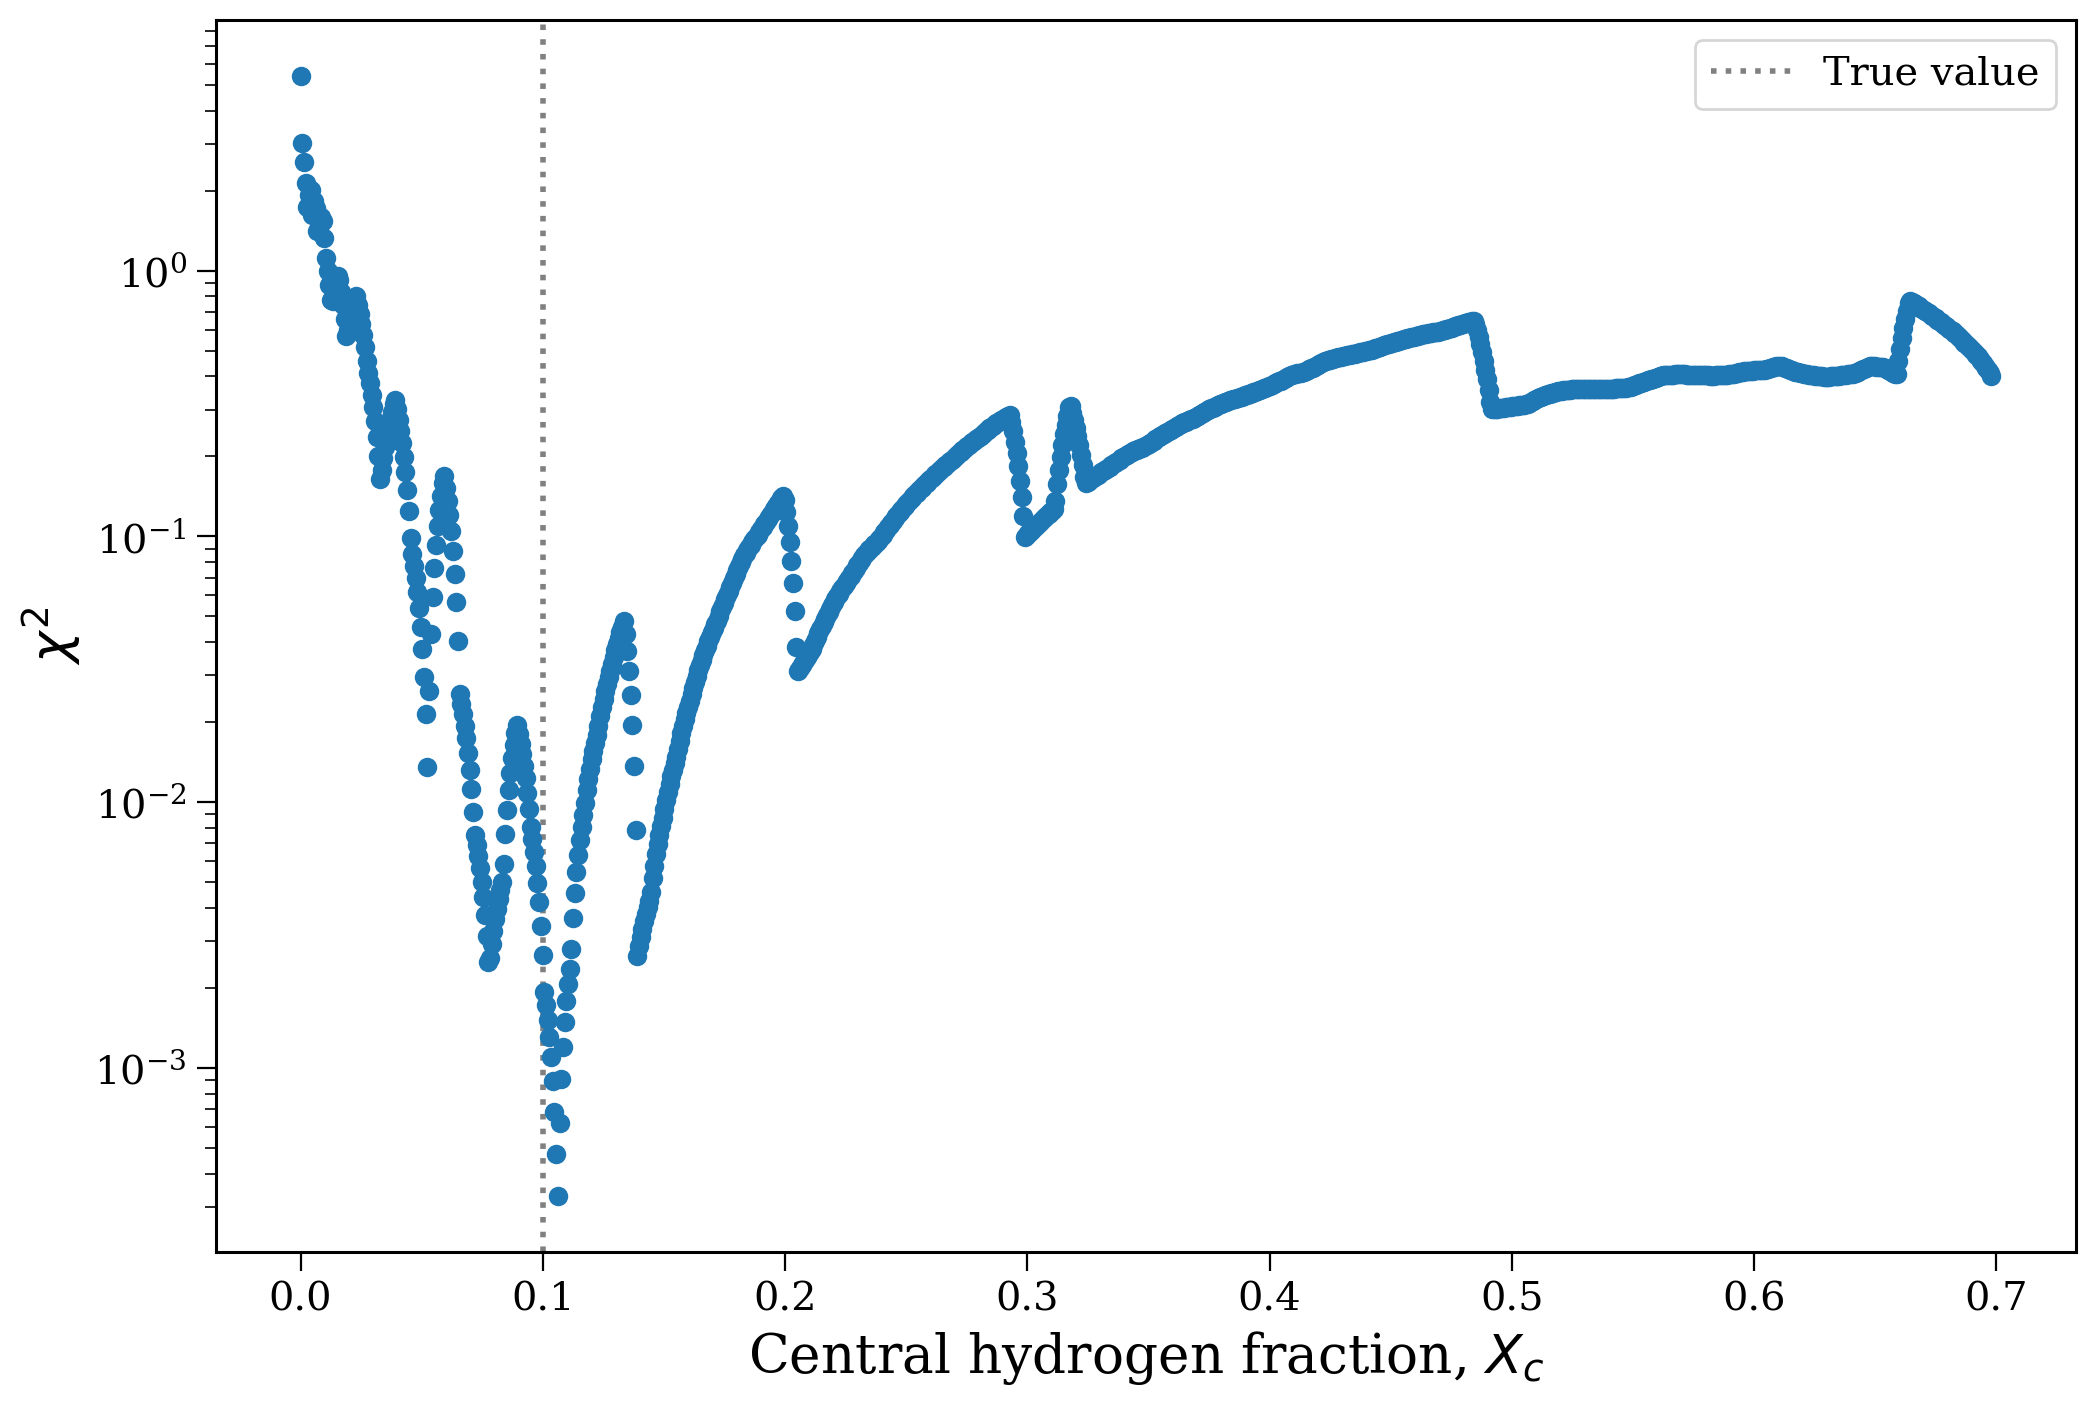

In [144]:
plt.scatter(x_c_range, chi_funcs[5](x_c_range), marker="o")
print(min(chi_funcs[5](x_c_range)))
plt.yscale("log")

plt.axvline(0.1, color="grey", linestyle="dotted", lw=2, zorder=-1, label="True value")

plt.xlabel(r"Central hydrogen fraction, $X_c$")
plt.ylabel(r"$\chi^2$")

plt.legend()

plt.show()

In [92]:
chi_funcs[0](x_cs[0])

array([5.82586215e+00, 7.64338364e-02, 9.55886965e-02, 3.13024189e-01,
       9.66769880e-02, 8.74240792e-02, 7.70274553e-02, 6.78167552e-02,
       6.07524798e-02, 5.60397918e-02, 5.35885372e-02, 5.29959807e-02,
       5.40400002e-02, 5.63356154e-02, 5.94274446e-02, 6.28380962e-02,
       6.62323228e-02, 6.98801156e-02, 7.29021366e-02, 7.60138376e-02,
       7.94304640e-02, 8.32435172e-02, 2.88214804e-01, 2.96503019e-01,
       9.62785501e-02, 3.16255362e-01, 1.07639723e-01, 3.37840236e-01,
       1.21095775e-01, 1.26965870e-01, 1.38153435e-01, 1.51034844e-01,
       1.63312170e-01, 1.78588758e-01, 1.96556067e-01, 1.12412636e-01,
       6.44110476e-02, 7.64835549e-02, 8.40269375e-02, 8.86446575e-02,
       7.50627220e-02, 6.79922787e-02, 7.34034422e-02, 2.73645066e-01,
       7.95654560e-02, 1.92937972e-01, 8.81043617e-02, 7.32954588e-02,
       7.46198149e-02, 7.48915087e-02, 7.65850485e-02, 7.75643254e-02,
       4.44054148e-02, 4.74699058e-02, 6.06086067e-02, 5.73032062e-02,
      

In [77]:
single_tracks[mod_name].history["center_h1"].iloc[np.argmin(chis)]

Parsing M_6.0


0.0013185744481231823

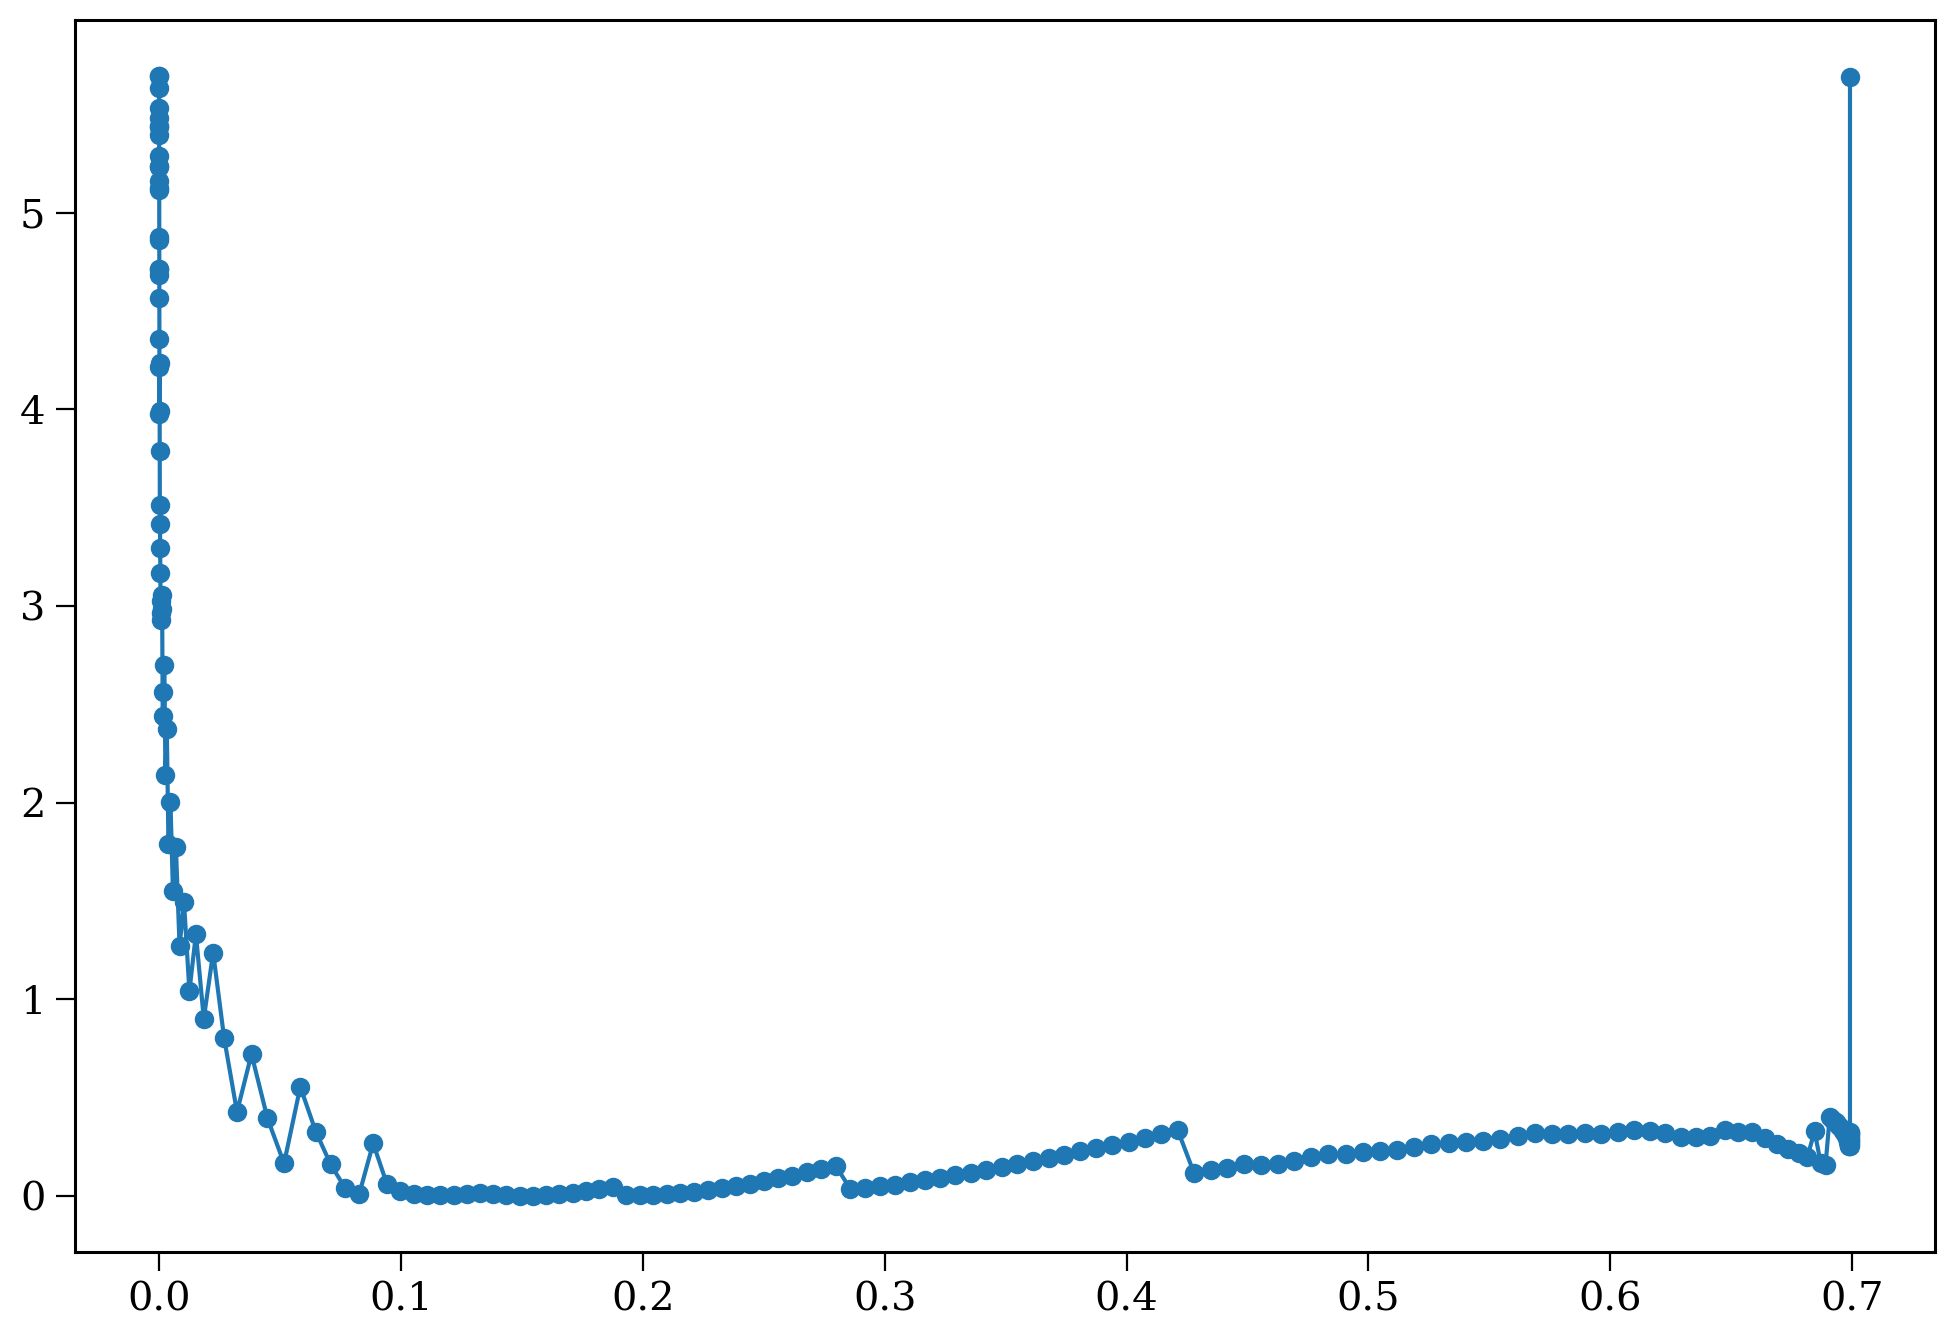

In [68]:
plt.plot(single_tracks["M_3.3"].history["center_h1"], chis, marker="o")
# plt.xscale("log")

In [64]:
chis

[5.6889691515402925,
 0.28504174610236205,
 0.3172632004288813,
 0.32588292705327326,
 0.3189749648506196,
 0.304255240273716,
 0.2878054113116084,
 0.27331550566806007,
 0.26257542278263535,
 0.25594660117286,
 0.25326207909769344,
 0.2540116760427431,
 0.25742087142874476,
 0.2626361785397593,
 0.26894952906571035,
 0.2754976516261052,
 0.28191453416789436,
 0.2881777172621464,
 0.29445049960382547,
 0.3011210967600664,
 0.3082406888130392,
 0.31572522432245953,
 0.32366533999567154,
 0.33200670206715693,
 0.3407765324987302,
 0.3514732346344501,
 0.3620289441959387,
 0.3741163110414736,
 0.38767718524067224,
 0.3989437987897357,
 0.15660612450235778,
 0.16963774974544465,
 0.32932688368600416,
 0.19799445591287607,
 0.2173145897329455,
 0.23898126470154202,
 0.26489395144236016,
 0.2927788364451569,
 0.32425378336022515,
 0.32476267108424983,
 0.3341274488398307,
 0.30593354099868875,
 0.3008051694076693,
 0.30174626064003024,
 0.322321167141986,
 0.329609391907379,
 0.3348902244634

In [17]:
p_mg = np.sort(p_mg.to(u.d).value)

array([1.06221171, 1.10711705, 1.17266906, 1.22106978, 1.28300119,
       1.33355387, 1.39406007, 1.44752398, 1.50431915, 1.56205876,
       1.61447527, 1.6747117 , 1.72601564, 1.78700848, 1.83650036,
       1.89917335, 1.94642529, 2.0101604 , 2.05867887, 2.11990028])

In [12]:


x = [1.2, 1.4, 1.6]
y = [0.9, 1.2, 1.9]

dists = np.zeros((len(x), len(y)))
x_ind, y_ind = np.arange(len(x)), np.arange(len(y))
for i, j in product(x_ind, y_ind):
    dists[i, j] = abs(x[i] - y[j])

print(dists)

opt_assignment = linear_sum_assignment(dists)

for i, j in zip(*opt_assignment):
    print(x[i], y[j])

[[0.3 0.  0.7]
 [0.5 0.2 0.5]
 [0.7 0.4 0.3]]
1.2 1.2
1.4 0.9
1.6 1.9


In [94]:
def wrapper(X_c=None, age=None, tracks=None, labels=['Mass-gainer', 'Single'], colours=[(0.390384, 0.100379, 0.501864, 1.0), (0.994738, 0.62435, 0.427397, 1.0)], legend_loc='upper left', label_with='an', x_var='period', label_modes=False, xlims=None, ylims=None, divide_delta_n=False, drop_duplicate_ng=True, fig=None, ax=None, show=True, ylim_auto_fac=2):
    return mpt.plot_period_spacing(**locals())


In [97]:
np.arange(0.7, 0.0, -0.01)

array([0.7 , 0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 ,
       0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49,
       0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38,
       0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27,
       0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16,
       0.15, 0.14, 0.13, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05,
       0.04, 0.03, 0.02, 0.01])

In [104]:
fig, ax = plt.subplots(figsize=(7, 3))

max_time = int(single_tracks["M_3.5"].history["star_age"].max() / 1e6)
timesteps = np.concatenate((np.arange(20, max_time, 2), [max_time] * 10))
# X_c = 

plt.tight_layout()

ani = FuncAnimation(fig, wrapper, np.arange(0.68, 0.0, -0.0075),
                    fargs=(None, [single_tracks["M_3.5"]], [r"$3.5 \rm{M_\odot}$ single star"], [mpt.single_col], "upper right", "an", "period", False, None, "auto", True, True, fig, ax, False, 2), repeat=True)

writer = animation.PillowWriter(fps=5,
                                metadata=dict(artist='Tom'),
                                bitrate=1800)
ani.save('period_spacing_animation.gif', writer=writer, dpi=300)

plt.show()

In [ ]:
single_tracks["M_3.5"]

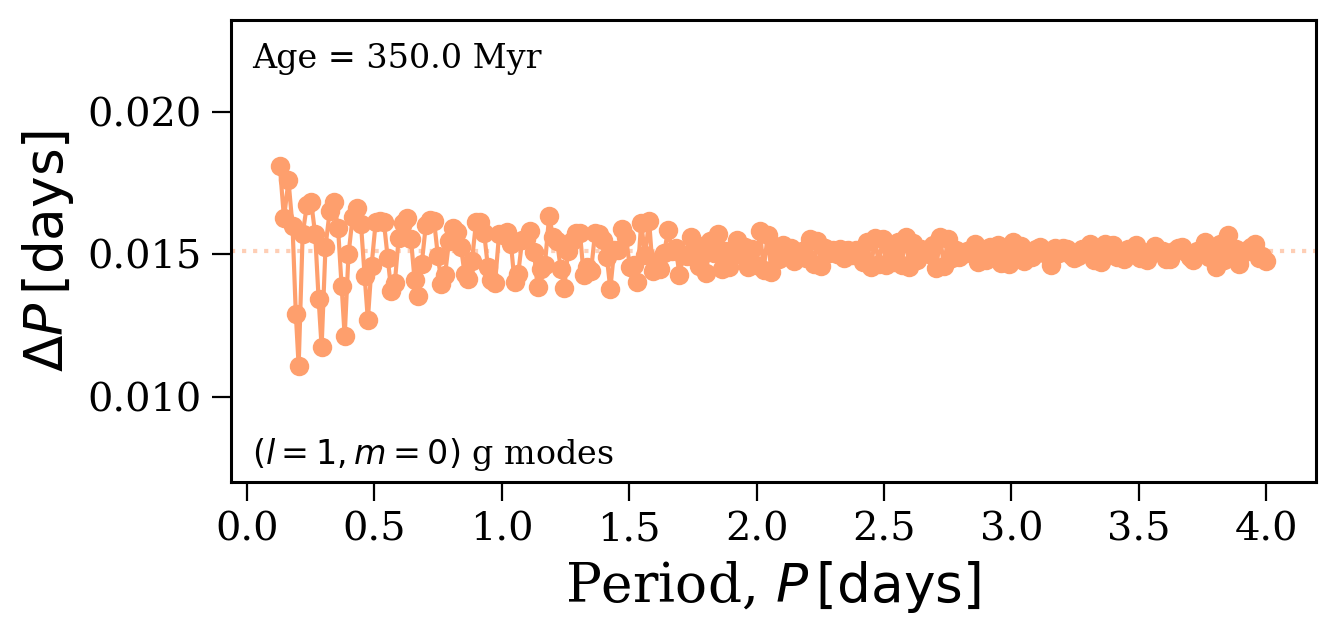

In [78]:
fig, ax, _, _ = mpt.plot_period_spacing(tracks=[single_tracks["M_3.5"]], age=350, show=False, ylims="auto", colours=[mpt.single_col])
# ax.set_ylim(0.02, 0.07)
ax.get_legend().remove()
plt.show()

Parsing M_3.0
CPU times: user 698 ms, sys: 22.8 ms, total: 721 ms
Wall time: 785 ms


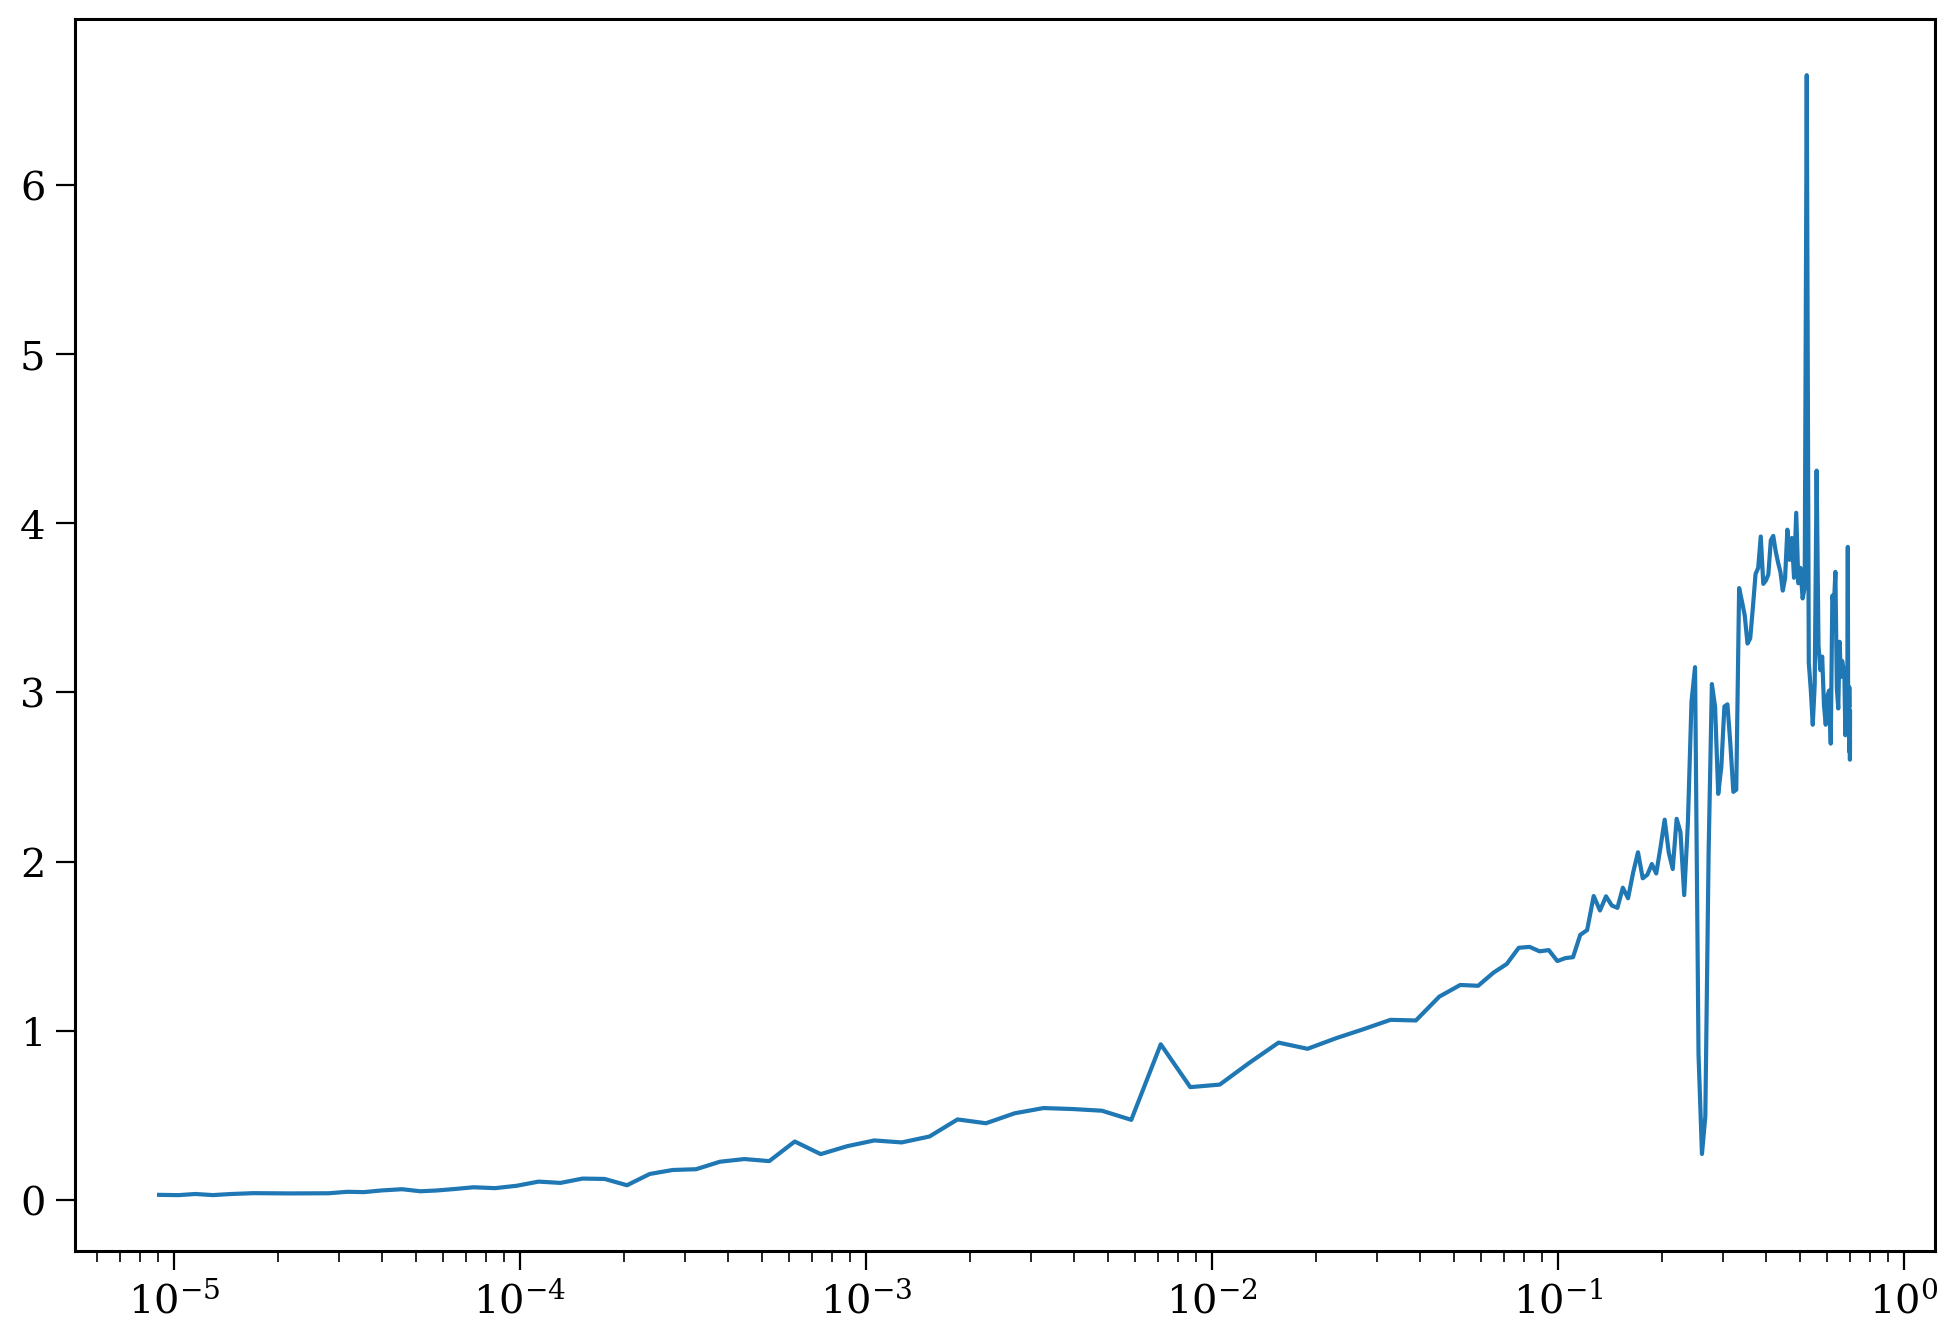

In [54]:
%%time

model = "M_3.0"

p_mg, ng_mg, dp_mg = mpt.get_delta_p(track, X_c=0.1)
chi2 = [None for _ in range(len(single_tracks[model].profiles))]
for i in range(len(single_tracks[model].profiles)):
    p_s, ng_s, dp_s = mpt.get_delta_p(single_tracks[model], mod=i + 1)
    # print(len(p_s))
    chi2[i] = chi2_2D(p_mg, dp_mg, p_s, dp_s) / len(p_s)

plt.plot(single_tracks[model].history["center_h1"], chi2)
plt.xscale("log")

In [27]:
for M in Ms:
    folder = f"M_{M:1.1f}"
    print(len(single_tracks[folder].freqs))

191


 10%|█         | 20/191 [00:00<00:01, 164.55it/s]

100%|██████████| 191/191 [00:00<00:00, 504.03it/s]


191


100%|██████████| 190/190 [00:00<00:00, 1323.70it/s]


190


100%|██████████| 190/190 [00:00<00:00, 694.61it/s]


190


100%|██████████| 190/190 [00:00<00:00, 1036.53it/s]


190


100%|██████████| 190/190 [00:00<00:00, 979.00it/s]


190


100%|██████████| 190/190 [00:00<00:00, 849.95it/s]


190


100%|██████████| 190/190 [00:00<00:00, 859.42it/s]


190


100%|██████████| 190/190 [00:00<00:00, 954.41it/s] 


190


100%|██████████| 190/190 [00:00<00:00, 855.58it/s] 


190


100%|██████████| 190/190 [00:00<00:00, 942.14it/s] 


190


100%|██████████| 189/189 [00:00<00:00, 516.41it/s]


189


100%|██████████| 190/190 [00:00<00:00, 944.51it/s]


190


100%|██████████| 199/199 [00:00<00:00, 1206.83it/s]


199


100%|██████████| 197/197 [00:00<00:00, 1328.48it/s]


197


100%|██████████| 192/192 [00:00<00:00, 1227.85it/s]


192


100%|██████████| 189/189 [00:00<00:00, 1274.48it/s]


189


100%|██████████| 188/188 [00:00<00:00, 2169.02it/s]


188


100%|██████████| 188/188 [00:00<00:00, 1190.44it/s]


188


100%|██████████| 188/188 [00:00<00:00, 1246.44it/s]


188


100%|██████████| 188/188 [00:00<00:00, 1520.92it/s]


188


100%|██████████| 188/188 [00:00<00:00, 957.55it/s]


188
187
187


100%|██████████| 193/193 [00:00<00:00, 1911.82it/s]


193


100%|██████████| 191/191 [00:00<00:00, 448.13it/s]


191


100%|██████████| 189/189 [00:00<00:00, 256.49it/s]


189


100%|██████████| 187/187 [00:00<00:00, 227.03it/s]


187


100%|██████████| 186/186 [00:00<00:00, 252.82it/s]


186


100%|██████████| 186/186 [00:00<00:00, 969.59it/s] 


186


100%|██████████| 186/186 [00:00<00:00, 1382.83it/s]

186


In [18]:
%%time
mpt.get_delta_p(single_tracks["M_3.0"], mod=4)

CPU times: user 2.47 ms, sys: 1.41 ms, total: 3.88 ms
Wall time: 3.76 ms


(<Quantity [3.96795902, 3.90782336, 3.84782347, 3.78797025, 3.72826748,
            3.66871552, 3.60932553, 3.55011889, 3.49110644, 3.43225544,
            3.37347136, 3.31463463, 3.25564699, 3.19644856, 3.13700289,
            3.07728515, 3.01729158, 2.9570504 , 2.89661869, 2.83605769,
            2.77540212, 2.71465092, 2.65378932, 2.59282176, 2.53177935,
            2.47071082, 2.40966883, 2.34869483, 2.2878071 , 2.22699401,
            2.16620914, 2.10540638, 2.04460849, 1.98389706, 1.92333527,
            1.86289083, 1.80245021, 1.74198279, 1.68160141, 1.62144928,
            1.56150428, 1.50157168, 1.44151329, 1.38137199, 1.32125189,
            1.26113634, 1.20092844, 1.14064611, 1.08051969, 1.02082404,
            0.96159683, 0.90248936, 0.84307289, 0.78322337, 0.72310671,
            0.66327725, 0.60388248, 0.54398503, 0.48296061, 0.42068136,
            0.35806032, 0.29606788, 0.2350841 , 0.1761782 ] d>,
 array([65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 

In [8]:
mpt.get_delta_p(track, X_c=0.4)

Parsing Mass-gainer


100%|██████████| 1046/1046 [00:00<00:00, 31958.58it/s]


(<Quantity [3.98999277, 3.91471918, 3.84138675, 3.77943137, 3.72131522,
            3.65066124, 3.57496636, 3.50179542, 3.43904433, 3.3805572 ,
            3.31142736, 3.23738064, 3.16539407, 3.10134124, 3.04049522,
            2.97169764, 2.89824629, 2.82643136, 2.76232189, 2.70206789,
            2.63386812, 2.56045955, 2.48858608, 2.42511652, 2.36509496,
            2.29642769, 2.22301908, 2.15159578, 2.0888484 , 2.02818811,
            1.95812464, 1.88369471, 1.81206751, 1.75167964, 1.69265177,
            1.62162753, 1.54660236, 1.4757125 , 1.41813025, 1.36012245,
            1.28882364, 1.21270499, 1.13774283, 1.07237837, 1.01529067,
            0.94705929, 0.87303017, 0.80754967, 0.76060029, 0.6915124 ,
            0.60879505, 0.52278756, 0.43730268, 0.36578938, 0.32904706,
            0.25808515] d>,
 array([58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42,
        41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25,
        24, 23, 22, 21, 20, 